# Import Libraries

In [43]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from category_encoders import OrdinalEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration

In [44]:
colors = ["#283149", "#404B69", "#DBEDF3", "#DBDBDB", "#FFFFFF"]

# Load Dataset

In [45]:
games = pd.read_csv('../data/games_clean.csv')

In [46]:
games['Release date'] = pd.to_datetime(games['Release date'])

In [47]:
games['Mac'] = games['Mac'].astype(int)

# Feature Engineering

## Functions

In [48]:
def scores_class(features : pd.DataFrame, target : pd.Series, discrete_features : str):
  score_classify = mutual_info_classif(features, target, discrete_features=discrete_features)
  scores = pd.DataFrame({
    'Feature': features.columns,
    'MI Score (Classify)': score_classify
  })
  return scores.sort_values(by = 'MI Score (Classify)', ascending = False)

def count_languages(word : str):
  word.replace("'", '')
  word.replace("[", '').replace("]", '')
  return len(word.split(','))

## Encode - Feature Categorical

In [49]:
categories = []
for i, row in games.iterrows():
    if type(row['Genres'].split(',')) == list:
        for cat in row['Genres'].split(','): categories.append(cat)

print(len(set(categories)))

33


In [50]:
one_hot_encode = pd.DataFrame()

for category in set(categories):
    cat = []
    for _, row in games.iterrows():
        cat.append(np.int64(category in row['Genres'].split(',')))
    one_hot_encode[category] = cat

one_hot_encode.head()

,Photo Editing,Game Development,Massively Multiplayer,Audio Production,Tutorial,Software Training,Sexual Content,Documentary,Strategy,Free to Play,...,RPG,Action,Video Production,Adventure,Racing,Early Access,Utilities,Education,Gore,Animation & Modeling
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,1,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [51]:
games = pd.concat((games, one_hot_encode), axis = 1)

In [52]:
games = games.drop(columns= ['Genres'])

In [53]:
ordinal_cols = ['Estimated owners']

In [54]:
mappings = [
    {
        'col' : 'Estimated owners',
        'mapping' : {
            '0 - 0'                 : 0,
            '0 - 20000'             : 1,
            '20000 - 50000'         : 2,
            '50000 - 100000'        : 3,
            '100000 - 200000'       : 4,
            '200000 - 500000'       : 5,
            '500000 - 1000000'      : 6,
            '1000000 - 2000000'     : 7,
            '2000000 - 5000000'     : 8,
            '5000000 - 10000000'    : 9,
            '10000000 - 20000000'   : 10,
            '20000000 - 50000000'   : 11,
            '50000000 - 100000000'  : 12,
            '100000000 - 200000000' : 13
        }
    }
]

In [55]:
ordinal_enc = OrdinalEncoder(cols = ordinal_cols, mapping= mappings)

In [56]:
games = ordinal_enc.fit_transform(games)

## New Features

In [57]:
# Count the number of operating systems the game is available on
games['Platform_count'] = games[['Windows', 'Mac', 'Linux']].sum(axis = 1)

In [58]:
# Number of achievements per hour of playtime
games['Achievements_per_hour'] = games.apply(
    lambda x : 
        x['Achievements'] 
        if x['Average playtime forever'] == 0 
        else x['Achievements'] / x['Average playtime forever'],
    axis = 1
)

In [59]:
# Amount of genres the game is available in
games['Genre_count'] = games[list(set(categories))].sum(axis = 1)

In [60]:
# Ratio of recent playtime to total playtime
games['Recent_playtime_ratio'] = games.apply(
    lambda x : 
        x['Average playtime two weeks'] 
        if x['Average playtime forever'] == 0 
        else x['Average playtime two weeks'] / x['Average playtime forever'],
    axis = 1
)

In [61]:
# Count the number of languages the game is available in
games['Language_count'] = games['Supported languages'].apply(count_languages)

In [62]:
# Ratio of quantity of operating systems the game is available on
games['OS_ratio'] = games[['Windows', 'Mac', 'Linux']].sum(axis = 1) / 3

In [63]:
# Antiquity of the game
games['Antiquity'] = (pd.to_datetime('today') - games['Release date']).dt.days

In [64]:
# Recommendations user based on the genre
games['Recommendation_per_genre'] = games['Recommendations'] / games['Genre_count']

In [65]:
games.drop(columns = ['Supported languages', 'Release date'], inplace = True)

## Normalization

### Robust Scaler

In [66]:
robust_columns = ['Negative', 'Achievements', 'Recommendations', 'Average playtime forever',
                  'Average playtime two weeks', 'Median playtime forever', 'Median playtime two weeks',
                  'Metacritic score', 'Positive', 'DLC count', 'Peak CCU']

In [67]:
robust_scaler = RobustScaler()
features_scaled = robust_scaler.fit_transform(games[robust_columns])

In [68]:
robust_df = pd.DataFrame(features_scaled, columns = robust_columns)

### Min-Max Scaler

In [69]:
min_max_columns = [ 'Price', 'Platform_count', 'Achievements_per_hour', 
                   'Genre_count', 'Recent_playtime_ratio', 'Language_count',
                   'OS_ratio', 'Antiquity', 'Recommendation_per_genre']

In [70]:
min_max_scaler = MinMaxScaler()
features_scaled = min_max_scaler.fit_transform(games[min_max_columns])

In [71]:
min_max_df = pd.DataFrame(features_scaled, columns= min_max_columns)

In [72]:
df_result = pd.concat((robust_df, min_max_df, games.drop(columns = robust_columns + min_max_columns)), axis = 1)

### Mutual Information

In [73]:
features = df_result.drop(columns=['Estimated owners'])
target = df_result['Estimated owners']

In [74]:
scores = scores_class(features, target, discrete_features = 'auto')

In [85]:
scores

,Feature,MI Score (Classify)
8,Positive,0.506482
0,Negative,0.447164
2,Recommendations,0.238176
19,Recommendation_per_genre,0.230844
3,Average playtime forever,0.226855
5,Median playtime forever,0.211896
18,Antiquity,0.193824
10,Peak CCU,0.185545
11,Price,0.171639
13,Achievements_per_hour,0.147026


In [75]:
drop_columns = scores[scores['MI Score (Classify)'] < 0.01]

In [76]:
games.drop(columns = drop_columns['Feature'].values, inplace = True)

### PCA

In [77]:
features = df_result[df_result.select_dtypes(include = 'number').columns]

In [78]:
pca = PCA(n_components = 5)
principal_components = pca.fit_transform(features_scaled)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

pca_df = pd.concat([pca_df, games[['Estimated owners']]], axis=1)

In [79]:
sum(pca.explained_variance_ratio_)

0.9986912311770977

In [80]:
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,Estimated owners
0,-0.194399,0.591831,0.388165,0.082425,-0.022716,1
1,0.455894,-0.255638,0.061793,-0.032873,0.069561,1
2,-0.247619,-0.052989,-0.073033,0.052059,-0.019081,1
3,1.168471,-0.082740,-0.078531,-0.001368,0.057441,1
4,0.449222,-0.300635,-0.015254,-0.054143,-0.010328,1


In [81]:
# Calculate percentage variation
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var) + 1)]

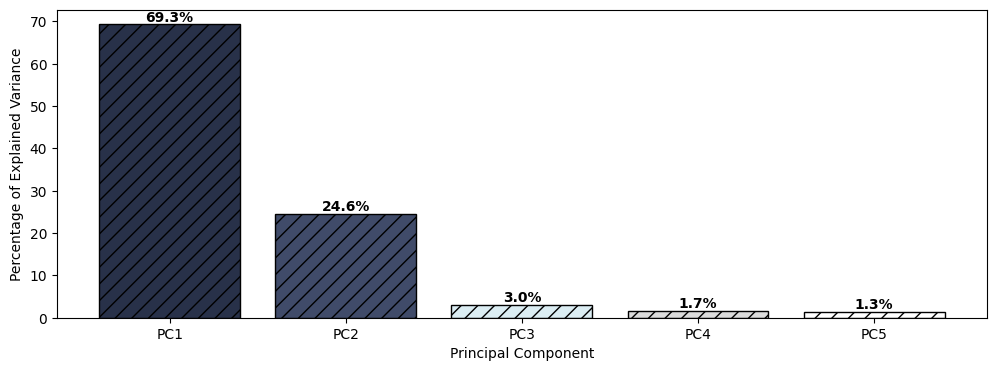

In [82]:
# Variance explained by each dimension
fig, ax = plt.subplots(figsize=(12, 4))
bars = ax.bar(x=range(1, len(per_var) + 1), height=per_var, tick_label=labels, color = colors, edgecolor='black', hatch='//')
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
for i, bar in enumerate(bars):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
            f'{per_var[i]}%', ha='center', va='bottom', color='black', fontweight='bold')
plt.show()

In [83]:
df_result = pd.concat((df_result, pca_df), axis = 1)

# Save dataset

In [84]:
df_result.to_csv('../data/games_normalized_clean.csv', index = False)